In [5]:
import numpy as np
import time
import random
from sklearn.cluster import KMeans
import torch
import openke
import matplotlib.pyplot as plt
from openke.config import Trainer, Tester
from openke.module.model import TransE, TransD, TransH
from openke.module.loss import MarginLoss
from openke.module.strategy import NegativeSampling
from openke.data import TrainDataLoader, TestDataLoader
import torch.nn.functional as F
import networkx as nx
from sklearn.cluster import SpectralClustering

In [6]:
!nvidia-smi

Fri Jun 14 19:22:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L40S                    Off | 00000000:01:00.0 Off |                    0 |
| N/A   61C    P0             219W / 350W |   4342MiB / 46068MiB |     87%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
def load_data(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    num_triples = int(lines[0].strip())
    triples = np.array([list(map(int, line.strip().split())) for line in lines[1:]])
    return num_triples, triples

def convert_to_batch_data(triples, device):
    batch_data = {
        'batch_h': torch.tensor([triple[0] for triple in triples], dtype=torch.long).to(device),
        'batch_t': torch.tensor([triple[1] for triple in triples], dtype=torch.long).to(device),
        'batch_r': torch.tensor([triple[2] for triple in triples], dtype=torch.long).to(device),
        'batch_y': torch.tensor([1 for _ in triples], dtype=torch.long).to(device),  
        'mode': "normal"
    }
    return batch_data

In [7]:
device = torch.device('cuda:1')
Train_dataloader = TrainDataLoader(
    in_path=None,
    tri_file='./benchmarks/YAGO3-10/remaining_0.1.txt',
    ent_file="./benchmarks/YAGO3-10/entity2id.txt",
    rel_file="./benchmarks/YAGO3-10/relation2id.txt",
    nbatches=100,
    threads=8,
    sampling_mode="normal",
    bern_flag=1,
    filter_flag=1,
    neg_ent=25,
    neg_rel=0)

In [8]:
Model = TransH(
	ent_tot = Train_dataloader.get_ent_tot(),
	rel_tot = Train_dataloader.get_rel_tot(),
	dim = 200, 
	p_norm = 1, 
	norm_flag = True)

In [9]:
Model.to(device)
Model = torch.load('./checkpoint/YAGO/YAGO_TransH.ckpt')

In [10]:
Model['ent_embeddings.weight']

tensor([[ 4.7182e-05, -2.2297e-03, -1.7224e-05,  ..., -5.6882e-04,
          1.3771e-04, -1.2485e-03],
        [ 3.0602e-03,  6.2708e-03,  3.0479e-03,  ...,  3.5679e-03,
          7.1930e-03,  7.5935e-03],
        [-3.5973e-04,  2.9162e-05,  5.9463e-03,  ..., -5.5361e-03,
          9.3293e-03,  2.1837e-04],
        ...,
        [-2.1864e-03,  2.3103e-03, -4.5022e-03,  ..., -4.2678e-03,
          6.7811e-04,  4.2009e-03],
        [-1.2137e-04, -3.1711e-03,  2.6538e-03,  ..., -1.8675e-03,
          5.1895e-03, -1.7089e-03],
        [ 1.0247e-02,  8.0756e-03,  1.1137e-02,  ..., -3.0951e-03,
         -5.7843e-03,  1.0830e-02]], device='cuda:0')

In [12]:
Model['ent_embeddings.weight'].shape

torch.Size([123182, 200])

In [13]:
Model['rel_embeddings.weight'].shape

torch.Size([37, 200])

In [14]:
num_triples, triples = load_data('./benchmarks/YAGO3-10/train2id.txt')

In [15]:
entity_embeddings = Model['ent_embeddings.weight'].cpu().numpy()

In [16]:
entity_embeddings

array([[ 4.7181922e-05, -2.2296542e-03, -1.7223832e-05, ...,
        -5.6881743e-04,  1.3770815e-04, -1.2484995e-03],
       [ 3.0601765e-03,  6.2708007e-03,  3.0478914e-03, ...,
         3.5679366e-03,  7.1930122e-03,  7.5934585e-03],
       [-3.5972617e-04,  2.9162262e-05,  5.9462618e-03, ...,
        -5.5360650e-03,  9.3292827e-03,  2.1836822e-04],
       ...,
       [-2.1863831e-03,  2.3102555e-03, -4.5021521e-03, ...,
        -4.2678025e-03,  6.7811448e-04,  4.2009451e-03],
       [-1.2137066e-04, -3.1710584e-03,  2.6538109e-03, ...,
        -1.8675094e-03,  5.1895254e-03, -1.7089008e-03],
       [ 1.0247482e-02,  8.0755707e-03,  1.1137070e-02, ...,
        -3.0951395e-03, -5.7842578e-03,  1.0830284e-02]], dtype=float32)

In [17]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(entity_embeddings)

In [18]:
labels = kmeans.labels_

In [19]:
labels.shape

(123182,)

In [20]:
from collections import Counter
label_counts = Counter(labels)

In [21]:
print("Label frequencies:")
for label, count in label_counts.items():
    print(f"The Number of the class {label}: {count}")

Label frequencies:
The Number of the class 0: 8867
The Number of the class 6: 19650
The Number of the class 5: 8631
The Number of the class 2: 26750
The Number of the class 3: 24231
The Number of the class 1: 7844
The Number of the class 8: 11272
The Number of the class 4: 8261
The Number of the class 7: 7675
The Number of the class 9: 1


In [ ]:
with open('node_clusters.txt', 'w') as file:
    for index, label in enumerate(labels):
        file.write(f"{index}\t{label}\n")

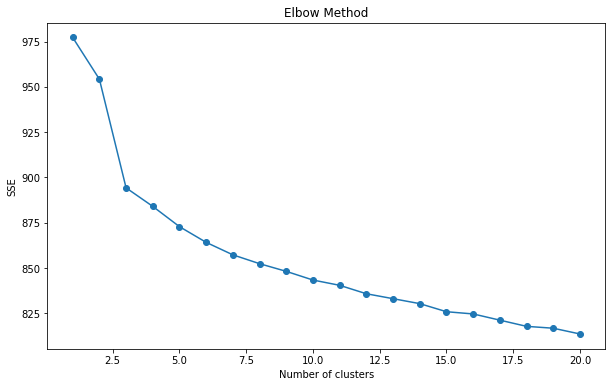

In [13]:
elbow_method(entity_embeddings, max_k)